In [1]:
from sklearn.preprocessing import StandardScaler, RobustScaler
from src.utils.data_loader import LoadDataSet, CustomDataSet
from src.positioning.toa import toa_positioning
from src.utils.models import DenseNet
from sklearn.decomposition import PCA
from torchsummary import summary
import matplotlib.pyplot as plt
import scipy.io as sio
import numpy as np
import tikzplotlib
import torch
import os
%matplotlib inline
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


### PCA Analysis

#### PCA with All Features Data
In this case we consider the data associated with each path, BS, and charcteristic (the 6 features for each path) as a unique set of features of dimension 600.

In [2]:
# Load the dataset with all the paths
dir_name = "Omni Spatial and Temporal Data/"
all_paths_dataset = LoadDataSet(dir_name, path_mode="all_paths")
print(f"Random shuffling state: {all_paths_dataset.rnd_state}")
scaler = StandardScaler()
train_set, test_set = all_paths_dataset.get_datasets(scale=True, scaler=scaler, add_noise=True)
train_dl = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
test_dl = torch.utils.data.DataLoader(test_set, batch_size=1024, shuffle=False)

54582
The shape of the feature data is (150000, 4, 25, 6)
The shape of the target data is: (150000, 3)
Random shuffling state: 3
(150000, 4, 25, 6)
(150000, 4, 25, 1)
The shape of the training data is: (75000, 4, 25, 6)
The shape of the testing data is: (75000, 4, 25, 6)
new training shape: (75000, 600)


In [3]:
# create the sk-learn PCA object and fit the training data
pca_all = PCA()
pca_all_components = pca_all.fit(train_set.X)

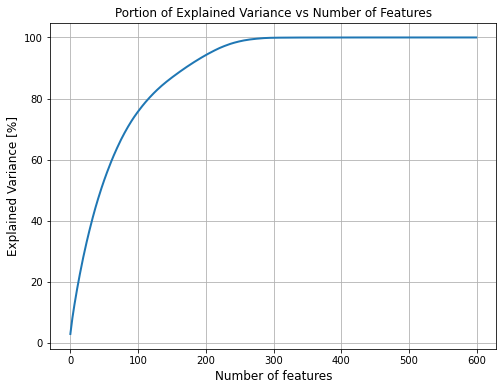

In [4]:
# let's visualize the amount of explained variance by increasing number of considered features
cum_explained_var = np.cumsum(pca_all_components.explained_variance_ratio_ * 100)
plt.figure(figsize=(8,6))
plt.plot(cum_explained_var, linewidth=2)
plt.xlabel("Number of features", fontsize=12)
plt.ylabel("Explained Variance [%]", fontsize=12)
plt.title("Portion of Explained Variance vs Number of Features")
plt.grid()

tikzplotlib.save("./figures/explained_variance_noise.tex")

In [5]:
# retain a number of features with which we can explain at least 95 % of the total variance
I = np.where(cum_explained_var >= 95)[0]
num_features_95 = I[0]
print(f"The number of features needed to explain 95 % of the variance is: {num_features_95}")

# create an sk-learn PCA object with the above number of components
pca_95 = PCA(n_components=I[0])
x_train_95 = pca_95.fit_transform(train_set.X)
x_test_95 = pca_95.transform(test_set.X)
print(f"The reduced training data has shape: {x_train_95.shape}")
print(f"The percentage of explained variance is: {np.sum(pca_95.explained_variance_ratio_)*100}")

# create data loaders with the nre reduced data
train_95_dl = torch.utils.data.DataLoader(CustomDataSet(x_train_95, train_set.y), batch_size=32, shuffle=True)
test_95_dl = torch.utils.data.DataLoader(CustomDataSet(x_test_95, test_set.y), batch_size=1024, shuffle=False)

The number of features needed to explain 95 % of the variance is: 207
The reduced training data has shape: (75000, 207)
The percentage of explained variance is: 94.86528255697881


#### PCA for each feature
In this case we consider the data associated with the 6 features (delay, rx power, and the 4 angles of arrival and departure).
Specifically, based on the PCA of the data matrix, we select the 3 features that have the highest explanation power in the dataset. Each feature has 100 singular values associated (25 paths x 4 Base Stations)

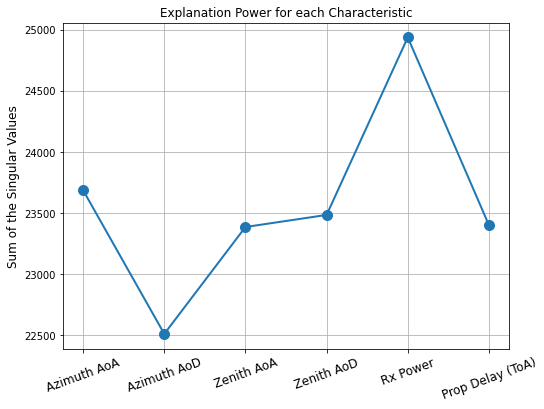

In [6]:
# we consider a PCA with 1 Principal Component to obtain the importance associated whith each characteristic
num_charac = 6
sinv_charac = np.zeros((num_charac, 1))
for i in range(num_charac):
    data = train_set.X[:, i*100:(i+1)*100]
    pca_i = PCA(100)
    pca_i_comp = pca_i.fit(data)
    sinv_charac[i] = np.sum(pca_i_comp.singular_values_)
    
plt.figure(figsize=(8,6))
plt.plot(sinv_charac, '-o', markersize=10, linewidth=2)
plt.ylabel("Sum of the Singular Values", fontsize=12)
plt.grid()
plt.title("Explanation Power for each Characteristic")
plt.xticks(np.arange(6), ["Azimuth AoA","Azimuth AoD","Zenith AoA","Zenith AoD","Rx Power","Prop Delay (ToA)"], rotation=20, fontsize=12)

tikzplotlib.save("./figures/characteristics_noise.tex")

From the plot above we can see that the 3 most important features are: Zenith AoD, Rx Power, and Propagation Delay.
Therefore, we will consider as input to our models the 100 samples (25x4) associated with these 3 characteristics, for a total of 300 features.

In [7]:
# get the full dataset
dir_name = "Omni Spatial and Temporal Data/"
full_dataset = LoadDataSet(dir_name, path_mode="all_paths")
print(f"Random shuffling state: {all_paths_dataset.rnd_state}")
scaler = StandardScaler()
(x_train, y_train), (x_test, y_test) = full_dataset.get_datasets(get_full_data=True, add_noise=True)

# selecting the feature corresponding to zenith AoD, Rx Power, and Propagation Delay (ToA) 
# [last 3 indexes in the right-most dimension]
x_train = np.reshape(x_train[:,:,:, [0,3,4]], (x_train.shape[0],x_train.shape[1]*x_train.shape[2]*3))
x_test = np.reshape(x_test[:,:,:,[0,3,4]], (x_test.shape[0],x_test.shape[1]*x_test.shape[2]*3))
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test) 
train_set = CustomDataSet(x_train, y_train)
test_set = CustomDataSet(x_test, y_test)

train_feature_based_dl = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
test_feature_based_dl = torch.utils.data.DataLoader(test_set, batch_size=1024, shuffle=False)

54582
The shape of the feature data is (150000, 4, 25, 6)
The shape of the target data is: (150000, 3)
Random shuffling state: 3
(150000, 4, 25, 6)
(150000, 4, 25, 1)
The shape of the training data is: (75000, 4, 25, 6)
The shape of the testing data is: (75000, 4, 25, 6)


## Train with the 95% variance explained features

In [8]:
in_dim = num_features_95
out_dim = all_paths_dataset.output_shape
layers_dim = [in_dim, 256, 64, out_dim]
dnn_model_95 = DenseNet(layers_dim)
dnn_model_95.to(device)
summary(dnn_model_95, input_data=(1,in_dim), device=device, depth=len(layers_dim))

Loss = torch.nn.MSELoss()
optimizer = torch.optim.Adam(dnn_model_95.parameters(), lr=0.001, amsgrad=False)

Layer (type:depth-idx)                   Output Shape              Param #
├─ModuleList: 1                          []                        --
|    └─Linear: 2-1                       [-1, 1, 256]              53,248
|    └─Linear: 2-2                       [-1, 1, 64]               16,448
|    └─Linear: 2-3                       [-1, 1, 3]                195
Total params: 69,891
Trainable params: 69,891
Non-trainable params: 0
Total mult-adds (M): 0.07
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.27
Estimated Total Size (MB): 0.27


In [9]:
# train the model
train_loss_history = []
test_loss_history = []
n_epochs = 500

for epoch in range(n_epochs):
    total_train_loss = 0
    total_test_loss = 0
    total_train = 0
    total_test = 0

    # training loop (iterate over the training set)
    for x, y in train_95_dl:
        x_train, y_train = x.float().to(device), y.float().to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
        train_output = dnn_model_95(x_train) # network output
        loss = Loss(train_output, y_train) # compute loss
        loss.backward() # compute gradient with respect to trainable parameters
        optimizer.step() # weights update
        total_train_loss += loss.item()
        total_train += 1

    print(f"Training at epoch: {epoch+1} ended, Loss: {total_train_loss/total_train}")
    # append training loss for the epoch
    train_loss_history.append(total_train_loss/total_train)

    # testing every 10 training epochs
    if ((epoch+1) % 10) == 0:
        for x, y in test_95_dl:
            x_test, y_test = x.float().to(device), y.float().to(device)
            test_output = dnn_model_95(x_test)
            loss = Loss(test_output, y_test)
            total_test_loss += loss.item()
            total_test += 1
        print(f"--> Testing at epoch: {epoch+1} ended, Loss: {total_test_loss/total_test}")
        # append test loss for the epoch
        test_loss_history.append(total_test_loss/total_test)

print('Finished Training')

Training at epoch: 1 ended, Loss: 6808.84757631061
Training at epoch: 2 ended, Loss: 2429.7254359014205
Training at epoch: 3 ended, Loss: 1860.125045802406
Training at epoch: 4 ended, Loss: 1651.231370580888
Training at epoch: 5 ended, Loss: 1466.0862052058196
Training at epoch: 6 ended, Loss: 1182.8291596682811
Training at epoch: 7 ended, Loss: 1167.036326815244
Training at epoch: 8 ended, Loss: 1046.8894665688786
Training at epoch: 9 ended, Loss: 903.4268276618202
Training at epoch: 10 ended, Loss: 861.2923995138435
--> Testing at epoch: 10 ended, Loss: 2202.1766382165856
Training at epoch: 11 ended, Loss: 1286.0549063503538
Training at epoch: 12 ended, Loss: 795.1728944550603
Training at epoch: 13 ended, Loss: 840.4746516751754
Training at epoch: 14 ended, Loss: 707.8459709154461
Training at epoch: 15 ended, Loss: 1209.4209663013548
Training at epoch: 16 ended, Loss: 674.7303220403886
Training at epoch: 17 ended, Loss: 641.4926046462596
Training at epoch: 18 ended, Loss: 654.0014732

--> Testing at epoch: 140 ended, Loss: 697.7812652587891
Training at epoch: 141 ended, Loss: 187.69436627606075
Training at epoch: 142 ended, Loss: 209.64067355439119
Training at epoch: 143 ended, Loss: 190.5400814424196
Training at epoch: 144 ended, Loss: 190.62109682258892
Training at epoch: 145 ended, Loss: 191.63091662800758
Training at epoch: 146 ended, Loss: 201.67550631187882
Training at epoch: 147 ended, Loss: 184.3064691035821
Training at epoch: 148 ended, Loss: 184.6362310058021
Training at epoch: 149 ended, Loss: 215.00946636655632
Training at epoch: 150 ended, Loss: 384.95451332847415
--> Testing at epoch: 150 ended, Loss: 743.2847636454815
Training at epoch: 151 ended, Loss: 178.30144248643427
Training at epoch: 152 ended, Loss: 257.19195541342776
Training at epoch: 153 ended, Loss: 187.1422470242497
Training at epoch: 154 ended, Loss: 240.3015771904903
Training at epoch: 155 ended, Loss: 255.00523047723868
Training at epoch: 156 ended, Loss: 348.06682714585963
Training at

Training at epoch: 276 ended, Loss: 209.16781541674618
Training at epoch: 277 ended, Loss: 208.6365795395887
Training at epoch: 278 ended, Loss: 209.24741377521295
Training at epoch: 279 ended, Loss: 210.17280580566197
Training at epoch: 280 ended, Loss: 210.53847475344818
--> Testing at epoch: 280 ended, Loss: 1537.531869424356
Training at epoch: 281 ended, Loss: 213.45461364329472
Training at epoch: 282 ended, Loss: 225.64462857685805
Training at epoch: 283 ended, Loss: 1038.2383563624307
Training at epoch: 284 ended, Loss: 207.2345497567499
Training at epoch: 285 ended, Loss: 202.12816538827005
Training at epoch: 286 ended, Loss: 203.58755341487532
Training at epoch: 287 ended, Loss: 206.18949863121372
Training at epoch: 288 ended, Loss: 224.80137525890467
Training at epoch: 289 ended, Loss: 208.81641033485073
Training at epoch: 290 ended, Loss: 213.71942659775144
--> Testing at epoch: 290 ended, Loss: 1366.0608569995777
Training at epoch: 291 ended, Loss: 212.61417105092124
Trainin

Training at epoch: 412 ended, Loss: 183.40521104832152
Training at epoch: 413 ended, Loss: 186.98524647605296
Training at epoch: 414 ended, Loss: 185.26986406931698
Training at epoch: 415 ended, Loss: 186.1514865530229
Training at epoch: 416 ended, Loss: 185.53713059669468
Training at epoch: 417 ended, Loss: 187.20141421568678
Training at epoch: 418 ended, Loss: 184.97588993827637
Training at epoch: 419 ended, Loss: 234.2284900906143
Training at epoch: 420 ended, Loss: 185.22437572804733
--> Testing at epoch: 420 ended, Loss: 1445.653963243639
Training at epoch: 421 ended, Loss: 188.2735047812348
Training at epoch: 422 ended, Loss: 468.7673401588466
Training at epoch: 423 ended, Loss: 190.41771449326654
Training at epoch: 424 ended, Loss: 183.82920517449492
Training at epoch: 425 ended, Loss: 182.7401776167313
Training at epoch: 426 ended, Loss: 182.84282158666096
Training at epoch: 427 ended, Loss: 300.64301132748966
Training at epoch: 428 ended, Loss: 189.23484301322964
Training at e

In [10]:
torch.save(dnn_model_95.state_dict(), "../models/dnn_model_95_v1_noise")

In [11]:
in_dim = num_features_95
out_dim = all_paths_dataset.output_shape
layers_dim = [in_dim, 256, 64, out_dim]
dnn_model_95 = DenseNet(layers_dim)
dnn_model_95.to(device)
dnn_model_95.load_state_dict(torch.load("../models/dnn_model_95_v1_noise"))

# evaluate the model over the entire data and the test data
train_error_95 = []
test_error_95 = []
all_error_95 = []

for xx, yy in train_95_dl:
    x_to_pred, y_true = xx.float().to(device), yy.float().to(device)
    pred = dnn_model_95(x_to_pred)
    error = torch.sqrt(torch.sum((y_true - pred)**2, dim=1)).to("cpu").detach().numpy()
    train_error_95.extend(error)
    all_error_95.extend(error)

for xx, yy in test_95_dl:
    x_to_pred, y_true = xx.float().to(device), yy.float().to(device)
    pred = dnn_model_95(x_to_pred)
    error = torch.sqrt(torch.sum((y_true - pred)**2, dim=1)).to("cpu").detach().numpy()
    all_error_95.extend(error)
    test_error_95.extend(error)

train_error_95 = np.array(train_error_95)
test_error_95 = np.array(test_error_95)
all_error_95 = np.array(all_error_95)

## Train over the 3 most relevant carachteristics

In [12]:
in_dim = 300
out_dim = all_paths_dataset.output_shape
layers_dim = [in_dim, 256, 64, out_dim]
dnn_model_3 = DenseNet(layers_dim)
dnn_model_3.to(device)
summary(dnn_model_3, input_data=(1,in_dim), device=device, depth=len(layers_dim))

Loss = torch.nn.MSELoss()
optimizer = torch.optim.Adam(dnn_model_3.parameters(), lr=0.001, amsgrad=False)

Layer (type:depth-idx)                   Output Shape              Param #
├─ModuleList: 1                          []                        --
|    └─Linear: 2-1                       [-1, 1, 256]              77,056
|    └─Linear: 2-2                       [-1, 1, 64]               16,448
|    └─Linear: 2-3                       [-1, 1, 3]                195
Total params: 93,699
Trainable params: 93,699
Non-trainable params: 0
Total mult-adds (M): 0.09
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.36
Estimated Total Size (MB): 0.36


In [13]:
# train the model
train_loss_history = []
test_loss_history = []
n_epochs = 500

for epoch in range(n_epochs):
    total_train_loss = 0
    total_test_loss = 0
    total_train = 0
    total_test = 0

    # training loop (iterate over the training set)
    for x, y in train_feature_based_dl:
        x_train, y_train = x.float().to(device), y.float().to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
        train_output = dnn_model_3(x_train) # network output
        loss = Loss(train_output, y_train) # compute loss
        loss.backward() # compute gradient with respect to trainable parameters
        optimizer.step() # weights update
        total_train_loss += loss.item()
        total_train += 1

    print(f"Training at epoch: {epoch+1} ended, Loss: {total_train_loss/total_train}")
    # append training loss for the epoch
    train_loss_history.append(total_train_loss/total_train)

    # testing every 10 training epochs
    if ((epoch+1) % 10) == 0:
        for x, y in test_feature_based_dl:
            x_test, y_test = x.float().to(device), y.float().to(device)
            test_output = dnn_model_3(x_test)
            loss = Loss(test_output, y_test)
            total_test_loss += loss.item()
            total_test += 1
        print(f"--> Testing at epoch: {epoch+1} ended, Loss: {total_test_loss/total_test}")
        # append test loss for the epoch
        test_loss_history.append(total_test_loss/total_test)

print('Finished Training')

Training at epoch: 1 ended, Loss: 5629.340109971603
Training at epoch: 2 ended, Loss: 2081.560106088684
Training at epoch: 3 ended, Loss: 1497.928775123362
Training at epoch: 4 ended, Loss: 1221.7471829176764
Training at epoch: 5 ended, Loss: 1010.459570757765
Training at epoch: 6 ended, Loss: 878.2646002297515
Training at epoch: 7 ended, Loss: 815.0236953826487
Training at epoch: 8 ended, Loss: 740.6472491371753
Training at epoch: 9 ended, Loss: 730.1406800201728
Training at epoch: 10 ended, Loss: 671.2143361088359
--> Testing at epoch: 10 ended, Loss: 4151.930305687157
Training at epoch: 11 ended, Loss: 592.4620476354918
Training at epoch: 12 ended, Loss: 578.3354790918656
Training at epoch: 13 ended, Loss: 678.4321023335635
Training at epoch: 14 ended, Loss: 529.1548832903136
Training at epoch: 15 ended, Loss: 518.3525629222596
Training at epoch: 16 ended, Loss: 467.5917722291914
Training at epoch: 17 ended, Loss: 470.66050452014287
Training at epoch: 18 ended, Loss: 426.37669626275

--> Testing at epoch: 140 ended, Loss: 6317.588329830685
Training at epoch: 141 ended, Loss: 43.58387458934719
Training at epoch: 142 ended, Loss: 45.971081560789116
Training at epoch: 143 ended, Loss: 43.740958665418134
Training at epoch: 144 ended, Loss: 43.971227049827576
Training at epoch: 145 ended, Loss: 44.740745868699136
Training at epoch: 146 ended, Loss: 63.83734873089774
Training at epoch: 147 ended, Loss: 59.85966184562383
Training at epoch: 148 ended, Loss: 51.43606260327349
Training at epoch: 149 ended, Loss: 44.08308614459868
Training at epoch: 150 ended, Loss: 40.67283072121721
--> Testing at epoch: 150 ended, Loss: 5931.988743550069
Training at epoch: 151 ended, Loss: 42.22030037661868
Training at epoch: 152 ended, Loss: 42.58472698662468
Training at epoch: 153 ended, Loss: 158.00218450128014
Training at epoch: 154 ended, Loss: 52.72199331330765
Training at epoch: 155 ended, Loss: 37.843521281313976
Training at epoch: 156 ended, Loss: 38.9067232812224
Training at epoch

Training at epoch: 277 ended, Loss: 22.79908187539911
Training at epoch: 278 ended, Loss: 23.23663580580376
Training at epoch: 279 ended, Loss: 20.93633283039002
Training at epoch: 280 ended, Loss: 21.313838091319738
--> Testing at epoch: 280 ended, Loss: 6504.381368070035
Training at epoch: 281 ended, Loss: 22.774980349955705
Training at epoch: 282 ended, Loss: 22.147313672934782
Training at epoch: 283 ended, Loss: 21.185825365802128
Training at epoch: 284 ended, Loss: 67.66328615987668
Training at epoch: 285 ended, Loss: 23.042102079342655
Training at epoch: 286 ended, Loss: 20.466707977825465
Training at epoch: 287 ended, Loss: 21.135560906584352
Training at epoch: 288 ended, Loss: 23.255825325490672
Training at epoch: 289 ended, Loss: 21.316104683249478
Training at epoch: 290 ended, Loss: 20.809659057916633
--> Testing at epoch: 290 ended, Loss: 6713.036823994405
Training at epoch: 291 ended, Loss: 21.00922570456417
Training at epoch: 292 ended, Loss: 21.72234488265913
Training at 

Training at epoch: 413 ended, Loss: 16.075982095641894
Training at epoch: 414 ended, Loss: 15.881943136555343
Training at epoch: 415 ended, Loss: 18.080120171194597
Training at epoch: 416 ended, Loss: 21.28664047298985
Training at epoch: 417 ended, Loss: 19.905877689147566
Training at epoch: 418 ended, Loss: 15.226218767438732
Training at epoch: 419 ended, Loss: 17.698015421527238
Training at epoch: 420 ended, Loss: 15.711685992141632
--> Testing at epoch: 420 ended, Loss: 6803.926386291916
Training at epoch: 421 ended, Loss: 15.378648958922247
Training at epoch: 422 ended, Loss: 15.46339131571327
Training at epoch: 423 ended, Loss: 15.374852919639581
Training at epoch: 424 ended, Loss: 15.94527059996901
Training at epoch: 425 ended, Loss: 15.212567352801052
Training at epoch: 426 ended, Loss: 15.483160988869521
Training at epoch: 427 ended, Loss: 15.438104457924391
Training at epoch: 428 ended, Loss: 15.403639251156472
Training at epoch: 429 ended, Loss: 24.9444515312491
Training at e

In [14]:
torch.save(dnn_model_3.state_dict(), "../models/dnn_model_3_v1_noise")

In [15]:
in_dim = 300
out_dim = all_paths_dataset.output_shape
layers_dim = [in_dim, 256, 64, out_dim]
dnn_model_3 = DenseNet(layers_dim)
dnn_model_3.to(device)
dnn_model_3.load_state_dict(torch.load("../models/dnn_model_3_v1_noise"))

# evaluate the model over the entire data and the test data
train_error_3 = []
test_error_3 = []
all_error_3 = []

for xx, yy in train_feature_based_dl:
    x_to_pred, y_true = xx.float().to(device), yy.float().to(device)
    pred = dnn_model_3(x_to_pred)
    error = torch.sqrt(torch.sum((y_true - pred)**2, dim=1)).to("cpu").detach().numpy()
    train_error_3.extend(error)
    all_error_3.extend(error)

for xx, yy in test_feature_based_dl:
    x_to_pred, y_true = xx.float().to(device), yy.float().to(device)
    pred = dnn_model_3(x_to_pred)
    error = torch.sqrt(torch.sum((y_true - pred)**2, dim=1)).to("cpu").detach().numpy()
    all_error_3.extend(error)
    test_error_3.extend(error)

train_error_3 = np.array(train_error_3)
test_error_3 = np.array(test_error_3)
all_error_3 = np.array(all_error_3)

### Results

In [16]:
# import baseline results
true_cord_tensor = sio.loadmat(os.path.abspath(os.path.join("../../"+dir_name, "all_true_tensor")))['true_cord_tensor']
tot_points = true_cord_tensor.shape[0]*true_cord_tensor.shape[1]
true_cord_tensor_r = np.reshape(true_cord_tensor, (tot_points, true_cord_tensor.shape[2]))

with open('../models/best_toa_estimated_noise.npy', 'rb') as f:
    best_est_3d_coords = np.load(f)
    
baseline_error = np.sqrt(np.sum((true_cord_tensor_r - best_est_3d_coords)**2, axis=1))

In [17]:
#hashim_baseline = sio.loadmat(os.path.abspath(os.path.join("../../"+dir_name, "baselineerror")))["err_data"].reshape(-1)
#print(hashim_baseline.shape)

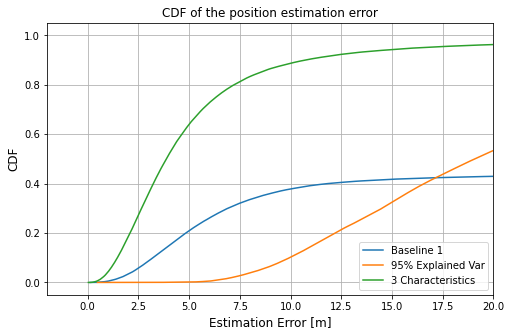

In [18]:
figure, ax = plt.subplots(1, 1, figsize=(8, 5)) 
ax.plot(np.sort(baseline_error), np.linspace(0,1,tot_points), np.sort(all_error_95), np.linspace(0,1,len(all_error_95)), 
       np.sort(all_error_3), np.linspace(0,1,len(all_error_3)))
tikzplotlib.clean_figure(fig=figure, target_resolution=600)

#plt.plot(np.sort(baseline_error), np.linspace(0,1,tot_points), linewidth=2, label="Baseline")
#plt.plot(np.sort(all_error), np.linspace(0,1,len(all_error)), linewidth=2, label="Min Delay")
#plt.plot(np.sort(all_error_all_paths), np.linspace(0,1,len(all_error_all_paths)), linewidth=2, label="All Paths")

plt.xlim([-2,20])
plt.ylabel("CDF", fontsize=12)
plt.xlabel("Estimation Error [m]", fontsize=12)
plt.title("CDF of the position estimation error")
plt.grid()
plt.legend(["Baseline 1", "95% Explained Var", "3 Characteristics", "Baseline 2"], loc="lower right")

tikzplotlib.save("./figures/pca_95_3charac_vs_baselines_noise.tex")
# plt.savefig("./dnn_vs_baseline.png")

In [22]:
print(all_error_95.shape)
# print(f"The average error for the Baseline is {np.mean(baseline_error)}")
# print(f"The average error for Hashim Baseline is {np.mean(hashim_baseline)}")
# print(f"The average error for the Min Delay DNN is {np.mean(all_error)}")
# print(f"The average error for the All Paths DNN is {np.mean(all_error_all_paths)}")

(150000,)


In [21]:
baseline_err_sort = np.sort(baseline_error)
y = np.linspace(0,1.0,len(baseline_err_sort))
print(f"BASELINE 1: the 80% percentile error in meters is {baseline_err_sort[y>=0.8][0]}")

#baseline_hash_sort = np.sort(hashim_baseline)
#y = np.linspace(0,1.0,len(baseline_hash_sort))
#print(f"BASELINE 2: the 80% percentile error in meters is {baseline_hash_sort[y>=0.8][0]}")

all_error_95_sort = np.sort(all_error_95)
y = np.linspace(0,1.0,len(all_error_95_sort))
print(f"95% Explained: the 80% percentile error in meters is {all_error_95_sort[y>=0.8][0]}")

all_error_3_sort = np.sort(all_error_3)
y = np.linspace(0,1.0,len(all_error_3_sort))
print(f"3 CHARACT: the 80% percentile error in meters is {all_error_3_sort[y>=0.8][0]}")


BASELINE 1: the 80% percentile error in meters is 377.8483316940807
95% Explained: the 80% percentile error in meters is 26.639102935791016
3 CHARACT: the 80% percentile error in meters is 7.216810703277588
